# Análise preditiva ARIMA

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_arima = pd.read_csv("GlobalLandTemperaturesByState.csv")
data_arima.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


<AxesSubplot:>

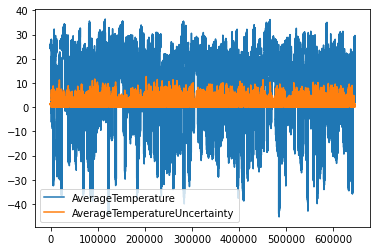

In [2]:
data_arima.plot()

In [213]:
#verificação de dada máxima, iremos considerar o mínimo como 1800
#print(data_arima['dt'].max())
# Convertendo a coluna "dt" para dados de data
data_arima['dt'] = pd.to_datetime(data_arima['dt'])
#observando análises anteriores foi possível notar que existe uma defasagem nos dados
#anteriores ao ano de 1800
data_arima.drop(data_arima[data_arima['dt']<='1800-01-01'].index, inplace=True)
data_arima.drop(data_arima[data_arima['dt']>='2013-09-01'].index, inplace=True)
data_arima.drop(data_arima[data_arima['State'] != 'Bahia'].index, inplace=True)
# Extraindo o ano da coluna "dt" para realizarmos uma análise por ano
data_arima["year"] = data_arima["dt"].dt.year

## Aqui começa a análise exploratória de dados para descobrir padrões e tendências, primeiro
## agrupando as temperaturas por ano e estado
dados_previsao = data_arima.groupby(["year","State"], as_index=False).mean()

## Limpeza dos dados utilizando o método .dropna() para remover linhas com valores ausentes 
data_arima.dropna(inplace=True)

dados_previsao.drop('AverageTemperatureUncertainty', axis=1, inplace=True)

dados_previsao.head()


,year,State,AverageTemperature
0,1832,Bahia,23.201917
1,1833,Bahia,23.958250
2,1834,Bahia,23.626250
3,1835,Bahia,22.881333
4,1836,Bahia,23.216417


In [214]:
dados_previsao.drop('State', axis=1, inplace=True)
dados_previsao.drop('year', axis=1, inplace=True)
dados_previsao.dropna(inplace=True)
#dados_previsao_log = np.log(dados_previsao)
#dados_previsao_log.plot()

In [215]:
msk = (dados_previsao.index < len(dados_previsao)-20)
df_train = dados_previsao[msk].copy()
df_test = dados_previsao[~msk].copy()

<AxesSubplot:>

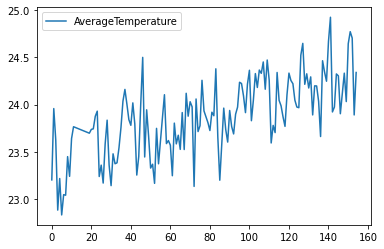

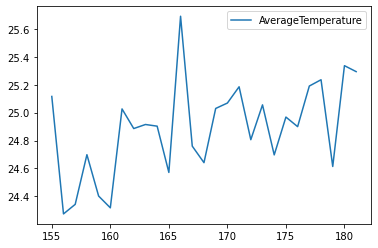

In [216]:
df_train.plot()
df_test.plot()

c:\Users\leona\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


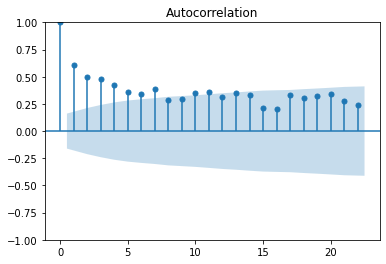

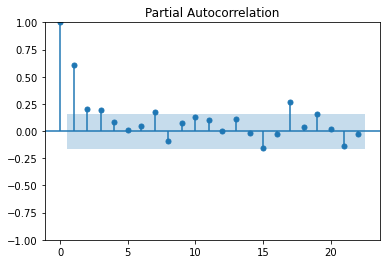

In [217]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

In [218]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
#print(f'p-value: {adf_test[1]}')

<AxesSubplot:>

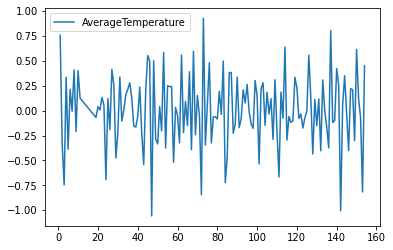

In [219]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

c:\Users\leona\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


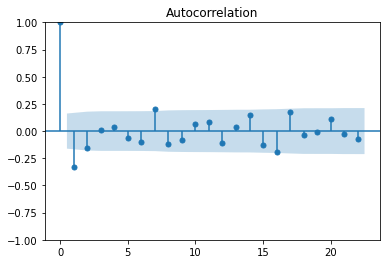

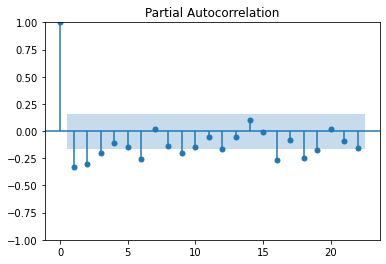

In [220]:
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

In [221]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 1.7276650515480208e-08


In [222]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(dados_previsao, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                  175
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -46.634
Date:                Fri, 20 Jan 2023   AIC                            105.267
Time:                        19:12:47   BIC                            124.221
Sample:                             0   HQIC                           112.956
                                - 175                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5958      0.074     -8.046      0.000      -0.741      -0.451
ar.L2         -0.5276      0.088     -5.999      0.000      -0.700      -0.355
ar.L3         -0.2769      0.099     -2.791      0.0

c:\Users\leona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\leona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\leona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


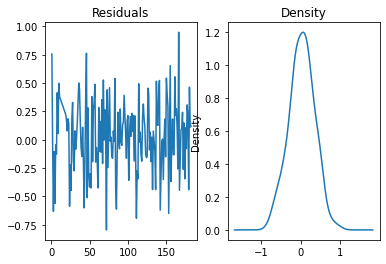

In [223]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

c:\Users\leona\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


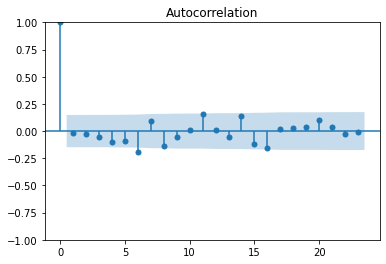

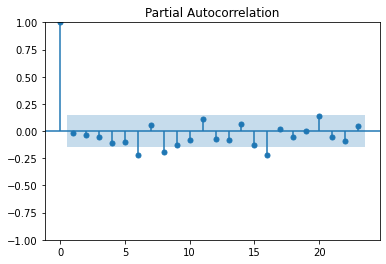

In [224]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

c:\Users\leona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot:>

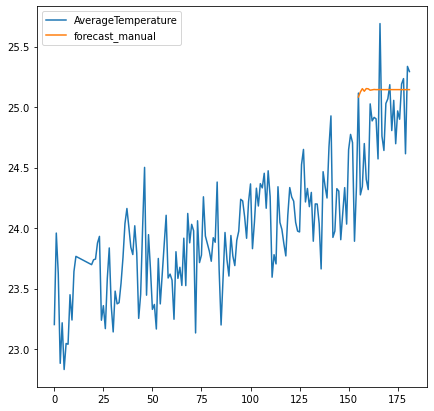

In [225]:
forecast_test = model_fit.forecast(len(df_test))

dados_previsao['forecast_manual'] = [None]*len(df_train) + list(forecast_test)


dados_previsao.plot(figsize=(7,7))

In [226]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(3, 1, 0), scoring_args={}, suppress_warnings=True)

In [227]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  148
Model:               SARIMAX(3, 1, 0)   Log Likelihood                 -37.745
Date:                Fri, 20 Jan 2023   AIC                             85.489
Time:                        19:12:56   BIC                            100.442
Sample:                             0   HQIC                            91.565
                                - 148                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0131      0.027      0.482      0.630      -0.040       0.066
ar.L1         -0.4948      0.081     -6.083      0.000      -0.654      -0.335
ar.L2         -0.3964      0.086     -4.635      0.000      -0.564      -0.229
ar.L3         -0.1960      0.076     -2.588      0.010      -0.344      -0.048
sigma2         0.0976      0.012      8.032      0.000       0.074       0.121
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.67
Prob(Q):                              0.85   Prob(JB):                         0.43
Heteroskedasticity (H):               0.83   Skew:                            -0.26
Prob(H) (two-sided):                  0.52   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\leona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot:>

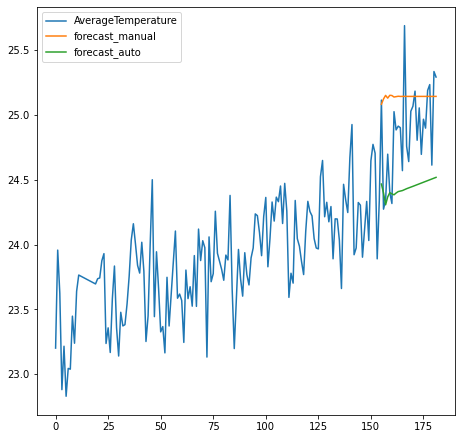

In [230]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
dados_previsao['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

dados_previsao.plot(figsize=(7.5,7.5))

In [229]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 0.3367005063894209
mape - manual: 0.013637982975395471
rmse - manual: 0.4227472846415356
